[IPython Notebook](limb_darkening.ipynb) |  [Python Script](limb_darkening.py)

Limb Darkening
============================

Setup
-----------------------------

As always, let's do imports and initialize a logger and a new bundle.  See [Building a System](../tutorials/building_a_system.html) for more details.

In [26]:
%matplotlib inline

In [27]:
import phoebe
from phoebe import u # units
import numpy as np
import matplotlib.pyplot as plt

logger = phoebe.logger()

b = phoebe.default_binary()

We'll just add 'lc' and 'mesh' datasets

In [28]:
b.add_dataset('lc', times=np.linspace(0,10,101), dataset='lc01')

<ParameterSet: 12 parameters | kinds: lc, lc_dep>

In [29]:
b.add_dataset('mesh', times=[0.75], dataset='mesh01')

<ParameterSet: 1 parameters>

Relevant Parameters
-----------------------------

In [30]:
print b['ld_func_bol@primary']

Parameter: ld_func_bol@primary@component
                       Qualifier: ld_func_bol
                     Description: Bolometric limb darkening model
                           Value: logarithmic
                         Choices: linear, logarithmic, quadratic, square_root, power



In [31]:
print b['ld_func_bol@primary'].choices

['linear', 'logarithmic', 'quadratic', 'square_root', 'power']


In [32]:
print b['ld_coeffs_bol@primary']

Parameter: ld_coeffs_bol@primary@component
                       Qualifier: ld_coeffs_bol
                     Description: Bolometric limb darkening coefficients
                           Value: [ 0.5  0.5]
                  Constrained by: 
                      Constrains: None
                      Related to: None



In [33]:
print b['ld_func@lc01']

ParameterSet: 2 parameters
    ld_func@primary@lc01@dataset: interp
  ld_func@secondary@lc01@dataset: interp


In [34]:
print b['ld_func@lc01@primary'].choices

['interp', 'linear', 'logarithmic', 'quadratic', 'square_root', 'power']


Note that ld_coeffs isn't visible (relevant) if ld_func=='interp'

In [35]:
b['ld_func@lc01@primary'] = 'logarithmic'

In [36]:
print b['ld_coeffs@lc01@primary']

Parameter: ld_coeffs@primary@lc01@dataset
                       Qualifier: ld_coeffs
                     Description: Limb darkening coefficients
                           Value: [ 0.5  0.5]
                  Constrained by: 
                      Constrains: None
                      Related to: None
                 Only visible if: ld_func:!interp



Influence on Light Curves (fluxes)
--------------------------

**TODO:** vary over different ld_func or ld_coeffs and show how they affect the LC

In [37]:
b.run_compute(model='mymodel')

<ParameterSet: 76 parameters | kinds: mesh, lc>

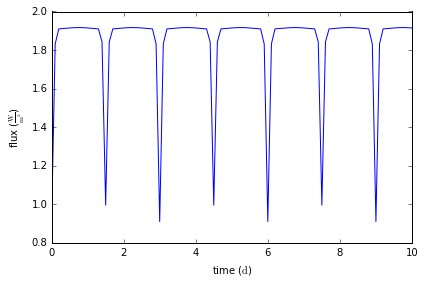

In [38]:
axs, artists = b['lc01@mymodel'].plot()

Influence on Meshes (Intesities)
-----------------------------------------

**TODO**: vary over different ld_func or ld_coeffs and show how they affect values and plots

In [39]:
#axs, artists = b['primary@MESH@mymodel'].plot(facecolor='ld', edgecolor=None)
# NOTE: limb-darkening is no longer exposed through the mesh (its included in intensities)